In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

from collections import defaultdict
from sklearn.utils import resample

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

<h4 style=color:blue> Load IMDB dataset & word index</h4>

In [3]:
#Remove early the least frequent words to prevent memory overflow
num_words = 20000 #keep top 20000 words
(x_train_full, y_train_full), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Split the full training data into training and development sets
x_train, x_dev, y_train, y_dev = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


word_index = imdb.get_word_index()
reverse_word_index = {index + 3: word for word, index in word_index.items()}
reverse_word_index[0], reverse_word_index[1], reverse_word_index[2], reverse_word_index[3] = "<PAD>", "<START>", "<UNK>", "<UNUSED>"

In [6]:
# Convert encoded review into a set of unique words. If i equals 1 its the <START> token so i need to skip it,
#i don't want to affect the classifier
def decode_review(encoded_review):
    return set(reverse_word_index.get(i, "<UNK>") for i in encoded_review if i>2)

x_train_words = [decode_review(review) for review in x_train]
x_dev_words = [decode_review(review) for review in x_dev]
x_test_words = [decode_review(review) for review in x_test]

In [8]:
def create_binary_feature_matrix(reviews, vocabulary):
    return [[1 if word in review else 0 for word in vocabulary] for review in reviews]

<h4 style=color:blue>Build vocabulary</h4>

In [11]:
def build_vocabulary(x_train_words,y_train, n, k, m):
    #Calculate word frequencies
    word_freq = defaultdict(int)
    for review in x_train_words:
        for word in review:
            word_freq[word] += 1

    
    #Remove n most frequent and k least frequent words
    sorted_words = sorted(word_freq.keys(), key=lambda x: word_freq[x], reverse=True)
    filtered_words = sorted_words[n:-k] if k > 0 else sorted_words[n:]

    top_words = sorted(word_freq.keys(), key=lambda x: word_freq[x], reverse=True)
    filtered_words = [word for word in filtered_words if word in top_words]
    
    X_train_binary = create_binary_feature_matrix(x_train_words, filtered_words)
    X_train_binary_array = np.array(X_train_binary, dtype=np.int8)

    #Mutual information for feature selection
    mi_scores = mutual_info_classif(X_train_binary_array, y_train)

    #Dictionary of words and their mutual information scores
    word_mi_scores = {word: score for word, score in zip(filtered_words, mi_scores)}
    #Select the top m words with the highest mutual information
    sorted_words_by_mi = sorted(word_mi_scores.keys(), key=lambda x: word_mi_scores[x], reverse=True)
    selected_vocabulary = sorted_words_by_mi[:m]
    
    return selected_vocabulary
    

In [13]:
class MultivariateBernoulliNB:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # Calculate class log priors
        self.class_log_prior_ = np.zeros(n_classes)
        for i, c in enumerate(self.classes_):
            self.class_log_prior_[i] = np.log(np.sum(y == c) / n_samples)

        # Calculate feature log probabilities
        self.feature_log_prob_ = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.feature_log_prob_[i, :] = np.log((np.sum(X_c, axis=0) + 1) / (np.sum(X_c) + n_features))

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_log_proba(X), axis=1)]

    def predict_log_proba(self, X):
        return (X @ self.feature_log_prob_.T) + self.class_log_prior_


Training - Validation - Testing

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
def train_dev_loop(x_train_words, y_train, x_dev_words, y_dev, m_values, n_values, k_values, train_sizes):
    best_f1 = 0
    best_metrics = {"train_precision": [], "train_recall": [], "train_f1": [], "dev_precision": [], "dev_recall": [], "dev_f1": []}

    # Lists to store metrics for learning curves
    train_precision, train_recall, train_f1 = [], [], []
    dev_precision, dev_recall, dev_f1 = [], [], []

    for m in m_values:
        for n in n_values:
            for k in k_values:
                print(f"Testing m={m}, n={n}, k={k}")

                vocabulary = build_vocabulary(x_train_words,y_train, n, k, m)

                X_train_features = create_binary_feature_matrix(x_train_words, vocabulary)
                X_dev_features = create_binary_feature_matrix(x_dev_words, vocabulary)

                for size in train_sizes:
                    #i+=1
                    n_samples = int(size* len(x_train_words))
                    x_train_subset = x_train_words[:n_samples]
                    y_train_subset = y_train[:n_samples]

                    X_train_subset_features = create_binary_feature_matrix(x_train_subset, vocabulary)

                    # Train the model
                    model = MultivariateBernoulliNB()
                    model.fit(np.array(X_train_subset_features), np.array(y_train_subset))

                     # Evaluate on the training set
                    y_train_pred = model.predict(np.array(X_train_subset_features))
                    train_precision.append(precision_score(y_train_subset, y_train_pred, pos_label=1))
                    train_recall.append(recall_score(y_train_subset, y_train_pred, pos_label=1))
                    train_f1.append(f1_score(y_train_subset, y_train_pred, pos_label=1))

                    # Evaluate on the development set
                    y_dev_pred = model.predict(np.array(X_dev_features))
                    dev_precision.append(precision_score(y_dev, y_dev_pred, pos_label=1))
                    dev_recall.append(recall_score(y_dev, y_dev_pred, pos_label=1))
                    dev_f1.append(f1_score(y_dev, y_dev_pred, pos_label=1))

                    print(f"Train size: {size * 100}%, Dev F1: {dev_f1[-1]}")

                    # Update best parameters if current F1 score is better
                    if dev_f1[-1] > best_f1:
                        best_f1 = dev_f1[-1]
                        best_params = {"m": m, "n": n, "k": k}
                        best_train_size = size
                        best_metrics["train_precision"] = train_precision
                        best_metrics["train_recall"] = train_recall
                        best_metrics["train_f1"] = train_f1
                        best_metrics["dev_precision"] = dev_precision
                        best_metrics["dev_recall"] = dev_recall
                        best_metrics["dev_f1"] = dev_f1

    print(f"Best parameters: {best_params}")
    print(f"Best train size: {best_train_size * 100}%")
    print(f"Best Dev F1: {best_f1}")

    return best_params, best_train_size, train_precision, train_recall, train_f1, dev_precision, dev_recall, dev_f1, best_metrics


In [24]:
#Define hyperparameters and train sizes to test
m_values = [1000]  # Number of words to select
n_values = [100, 150, 200]     # Number of most frequent words to remove
k_values = [500]      # Number of least frequent words to remove
train_sizes = [0.1, 0.2, 0.5]  # Percentage of training data to use


In [159]:
# Run the training-development loop
best_params, best_train_size, train_precision, train_recall, train_f1, dev_precision, dev_recall, dev_f1, best_metrics = train_dev_loop(x_train_words, y_train, x_dev_words, y_dev, m_values, n_values, k_values, train_sizes)


Testing m=1000, n=100, k=500
Train size: 10.0%, Dev F1: 0.8049760765550239
Train size: 20.0%, Dev F1: 0.8085271317829458
Train size: 50.0%, Dev F1: 0.8129454825659795
Testing m=1000, n=150, k=500
Train size: 10.0%, Dev F1: 0.802065404475043
Train size: 20.0%, Dev F1: 0.7931370637551179
Train size: 50.0%, Dev F1: 0.8006206361520558
Testing m=1000, n=200, k=500
Train size: 10.0%, Dev F1: 0.7898356897210547
Train size: 20.0%, Dev F1: 0.7811209439528024
Train size: 50.0%, Dev F1: 0.7893812219402694
Best parameters: {'m': 1000, 'n': 100, 'k': 500}
Best train size: 50.0%
Best Dev F1: 0.8129454825659795


<h3 style=color:blue>Retrain the model using best parameters and full training dataset size</h3>

In [18]:
best_params = {"m": 1000, "n": 100, "k": 500}
best_train_size = 0.5

In [ ]:
# Rebuild the vocabulary with the best parameters
vocabulary = build_vocabulary(x_train_words, y_train, best_params['n'], best_params['k'], best_params['m'])

# Convert the entire training set into binary features
X_train_features = create_binary_feature_matrix(x_train_words, vocabulary)

# Convert the test/dev set into binary features
X_dev_features = create_binary_feature_matrix(x_dev_words, vocabulary)

In [41]:
# Train the model on the full dataset
model = MultivariateBernoulliNB()
model.fit(np.array(X_train_features), np.array(y_train))

y_train_pred = model.predict(np.array(X_train_features))
full_train_precision = precision_score(y_train, y_train_pred, pos_label=1)
full_train_recall = recall_score(y_train, y_train_pred, pos_label=1)
full_train_f1 = f1_score(y_train, y_train_pred, pos_label=1)

print(f"Training with parameters: {best_params}")
print("Train size: 100%")
print(f"Precision: {full_train_precision}")
print(f"Recall: {full_train_recall}")
print(f"F1: {full_train_f1}")

Training with parameters: {'m': 1000, 'n': 100, 'k': 500}
Train size: 100%
Precision: 0.8138739618954568
Recall: 0.838281171379692
F1: 0.8258972833630776


In [47]:
y_dev_pred = model.predict(np.array(X_dev_features))
dev_precision = precision_score(y_dev, y_dev_pred, pos_label=1)
dev_recall = recall_score(y_dev, y_dev_pred, pos_label=1)
dev_f1 = f1_score(y_dev, y_dev_pred, pos_label=1)
print("Development:")
print(f"Precision: {dev_precision}")
print(f"Recall: {dev_recall}")
print(f"F1: {dev_f1}")

Development:
Precision: 0.8042744656917885
Recall: 0.8369098712446352
F1: 0.8202676864244742


In [49]:
X_test_features = create_binary_feature_matrix(x_test_words, vocabulary)
y_test_pred = model.predict(np.array(X_test_features))

In [79]:
print("Test Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=["Negative", "Positive"]))

# Micro- and macro-averaged metrics
micro_precision = precision_score(y_test, y_test_pred, average="micro")
micro_recall = recall_score(y_test, y_test_pred, average="micro")
micro_f1 = f1_score(y_test, y_test_pred, average="micro")

macro_precision = precision_score(y_test, y_test_pred, average="macro")
macro_recall = recall_score(y_test, y_test_pred, average="macro")
macro_f1 = f1_score(y_test, y_test_pred, average="macro")

print(f"Micro-Averaged Precision: {micro_precision}")
print(f"Micro-Averaged Recall: {micro_recall}")
print(f"Micro-Averaged F1: {micro_f1}")
print(f"Macro-Averaged Precision: {macro_precision}")
print(f"Macro-Averaged Recall: {macro_recall}")
print(f"Macro-Averaged F1: {macro_f1}")

Test Set Evaluation:
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81     12500
    Positive       0.80      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Micro-Averaged Precision: 0.8066
Micro-Averaged Recall: 0.8066
Micro-Averaged F1: 0.8066
Macro-Averaged Precision: 0.8066534312938687
Macro-Averaged Recall: 0.8066
Macro-Averaged F1: 0.8065915751290127


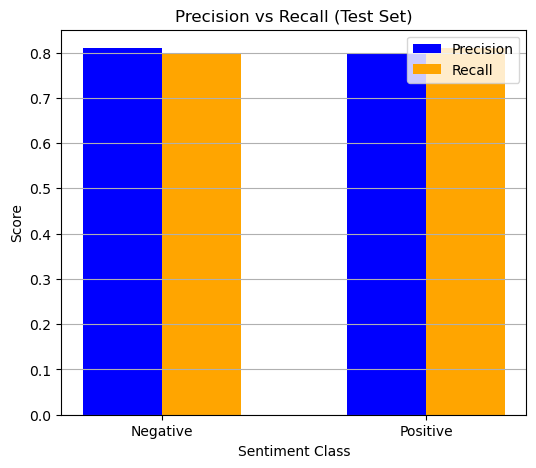

In [81]:
import matplotlib.pyplot as plt

classes = ["Negative", "Positive"]
precision = [0.81, 0.80]
recall = [0.80, 0.81]

x = np.arange(len(classes)) 
width = 0.3 

fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(x - width/2, precision, width, label='Precision', color='blue')
ax.bar(x + width/2, recall, width, label='Recall', color='orange')

ax.set_xlabel("Sentiment Class")
ax.set_ylabel("Score")
ax.set_title("Precision vs Recall (Test Set)")
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(axis='y')

plt.show()

In [83]:
import pandas as pd

data = {
    "Category": ["Negative", "Positive", "Micro-Averaged", "Macro-Averaged"],
    "Precision": [0.81, 0.80, 0.8066, 0.8066534312938687],  
    "Recall": [0.80, 0.81, 0.8066, 0.8066],    
    "F1 Score": [0.81, 0.81, 0.8066, 0.8065915751290127]    
}

df_results = pd.DataFrame(data)

print(df_results)

         Category  Precision  Recall  F1 Score
0        Negative   0.810000  0.8000  0.810000
1        Positive   0.800000  0.8100  0.810000
2  Micro-Averaged   0.806600  0.8066  0.806600
3  Macro-Averaged   0.806653  0.8066  0.806592


Performance across classes: the values indicate that the model performs similarly on both classes <br>
without favoring one over another. <br>
Micro-Averaged scores: treats all instances equally without bias <br>
Macro-Averaged scores: average metrics independantly per class

<h3 style=color:blue> PART B</h3>

In [87]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train_features, y_train)
y_pred_bnb = bnb.predict(X_test_features)
print("BernoulliNB (Scikit-learn):")
print(classification_report(y_test, y_pred_bnb))

BernoulliNB (Scikit-learn):
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     12500
           1       0.79      0.83      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



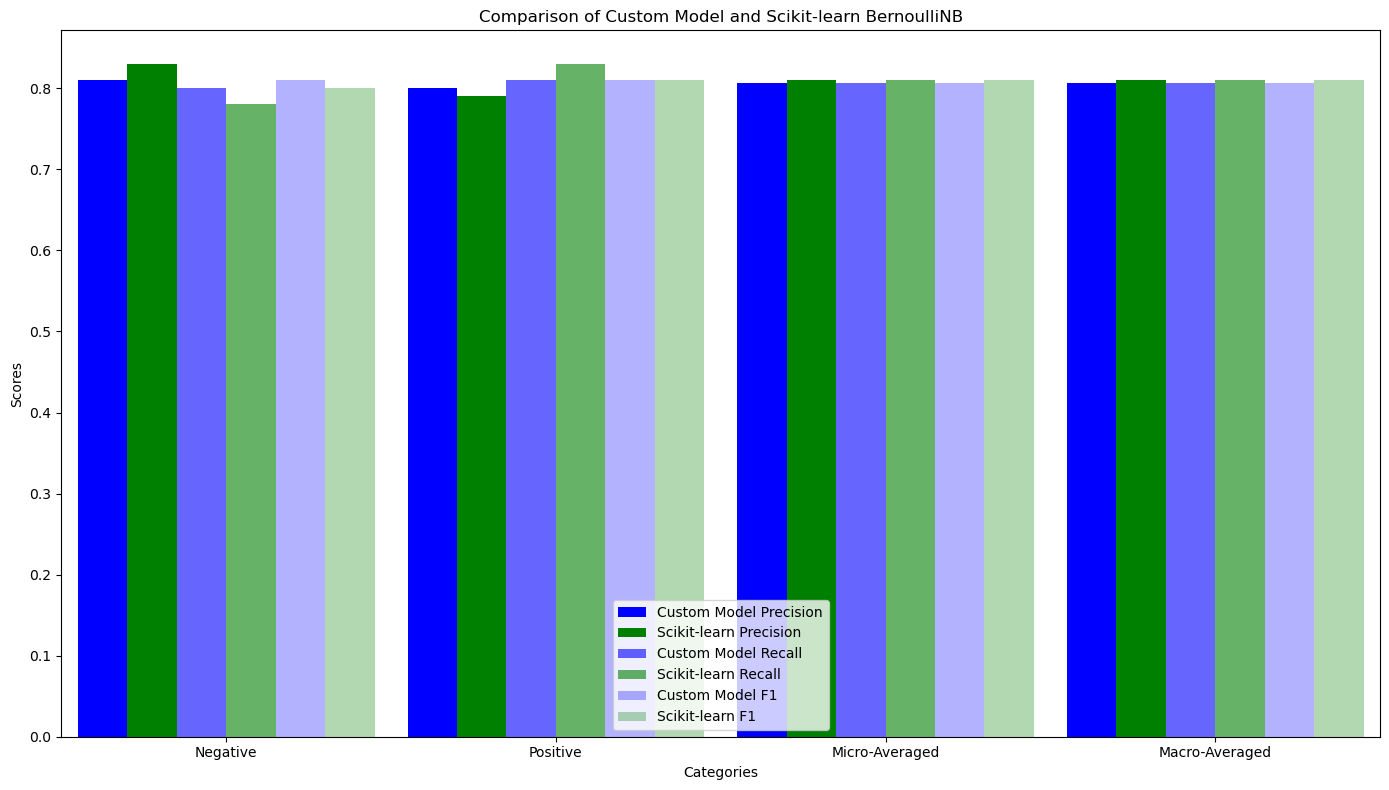

In [89]:
categories = ['Negative', 'Positive', 'Micro-Averaged', 'Macro-Averaged']

custom_precision = [0.810, 0.800, 0.8066, 0.806653]
custom_recall = [0.800, 0.810, 0.8066, 0.8066]
custom_f1 = [0.810, 0.810, 0.8066, 0.806592]


sklearn_precision = [0.83, 0.79, 0.81, 0.81]
sklearn_recall = [0.78, 0.83, 0.81, 0.81]
sklearn_f1 = [0.80, 0.81, 0.81, 0.81]

bar_width = 0.15 
index = np.arange(len(categories))

fig, ax = plt.subplots(figsize=(14, 8))

bar1 = ax.bar(index - 2.5 * bar_width, custom_precision, bar_width, label='Custom Model Precision', color='b')
bar2 = ax.bar(index - 1.5 * bar_width, sklearn_precision, bar_width, label='Scikit-learn Precision', color='g')

bar3 = ax.bar(index - 0.5 * bar_width, custom_recall, bar_width, label='Custom Model Recall', color='b', alpha=0.6)
bar4 = ax.bar(index + 0.5 * bar_width, sklearn_recall, bar_width, label='Scikit-learn Recall', color='g', alpha=0.6)

bar5 = ax.bar(index + 1.5 * bar_width, custom_f1, bar_width, label='Custom Model F1', color='b', alpha=0.3)
bar6 = ax.bar(index + 2.5 * bar_width, sklearn_f1, bar_width, label='Scikit-learn F1', color='g', alpha=0.3)

ax.set_xlabel('Categories')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Custom Model and Scikit-learn BernoulliNB')

ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.set_xlim(-0.5, len(categories) - 0.5) 

ax.legend()
plt.tight_layout()
plt.show()

<h2 style=color:blue>PART C</h2>

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim

class BiLSTM_RNN(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=64, num_layers=1, dropout=0.2, pre_trained_embeddings=None):
        super(BiLSTM_RNN, self).__init__()

        # Word Embedding layer
        if pre_trained_embeddings is not None:
            # If pre-trained embeddings are given, use them
            self.embedding = nn.Embedding.from_pretrained(pre_trained_embeddings, freeze=False)
        else:
            # Otherwise, use randomly initialized embeddings
            self.embedding = nn.Embedding(vocab_size, embed_size)

        # Stacked Bidirectional LSTM layers
        self.lstm = nn.LSTM(input_size=embed_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=True)

        # Global Max Pooling layer (max pooling across the entire sequence)
        self.pooling = nn.AdaptiveMaxPool1d(1)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size * 2, 1)  # *2 for bidirectional

        # Sigmoid for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)
        
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Apply Global Max Pooling across the sequence length (dimension 1)
        lstm_out = lstm_out.permute(0, 2, 1)  # Shape (batch_size, hidden_dim*2, seq_len)
        pooled_out = self.pooling(lstm_out).squeeze(2)  # Shape (batch_size, hidden_dim*2)

        # Pass through the fully connected layer
        out = self.fc(pooled_out)

        # Apply sigmoid for binary classification
        out = self.sigmoid(out)
        return out

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_preds = 0
        total_preds = 0

        for texts, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels.float())  # Squeeze for binary output
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate predictions
            preds = (outputs.squeeze() > 0.5).long()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        accuracy = correct_preds / total_preds
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy*100:.2f}%")

        # Evaluate on validation data
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

                preds = (outputs.squeeze() > 0.5).long()
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

        val_accuracy = correct_preds / total_preds
        print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy*100:.2f}%")

def predict_sentiment(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for texts, _ in test_loader:
            outputs = model(texts)
            preds = (outputs.squeeze() > 0.5).long()
            predictions.extend(preds.cpu().numpy())
    return predictions



In [1]:
def create_embedding_matrix(vocab, model, embed_size=100):
    """
    Create an embedding matrix where each word in the vocab is replaced with its word2vec vector.

    :param vocab: A dictionary of word to index.
    :param model: The pre-trained word2vec model.
    :param embed_size: Size of the word embeddings.
    :return: Embedding matrix of shape (vocab_size, embed_size).
    """
    embedding_matrix = np.zeros((len(vocab), embed_size))

    for word, idx in vocab.items():
        if word in model:
            embedding_matrix[idx] = model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_size,))
    return torch.tensor(embedding_matrix, dtype=torch.float)
